In [7]:
import galaxychop as gchop


gal = gchop.preproc.center_and_align(gchop.io.read_hdf5("tests/datasets/gal394242.h5"))

comp = gchop.models.AutoGaussianMixture(n_jobs=-2).decompose(gal)

gchop.models.GaussianMixture().get_attributes()

['normalized_star_energy', 'eps', 'eps_r']

In [4]:
comp

<Components length=272647, labels={0.0, 1.0, nan}, probabilities=True, lmap=False>

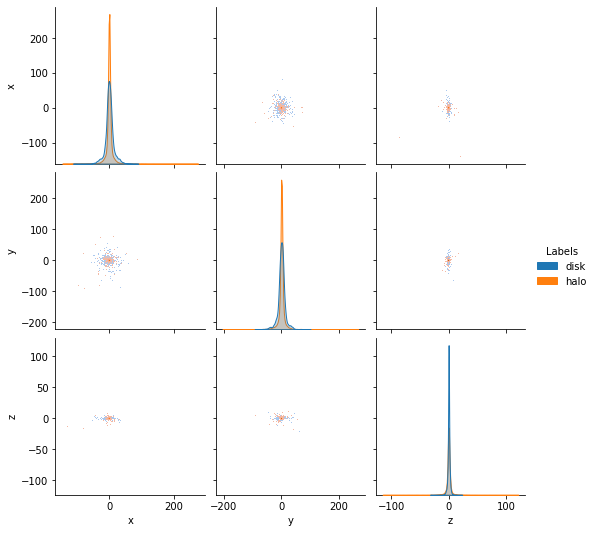

In [11]:
gal.plot.pairplot(attributes=["x", "y", "z"], labels=comp, lmap={0: "disk", 1: "halo"})

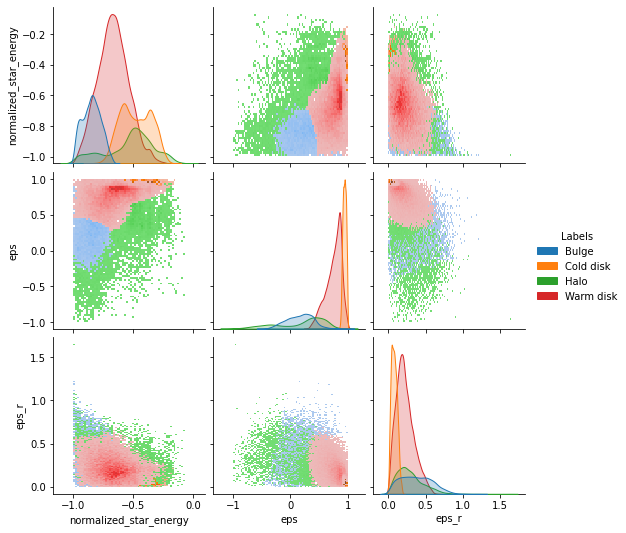

In [27]:
gal.plot.circ_pairplot(labels=comp, attributes=['normalized_star_energy', 'eps', 'eps_r'])

TypeError: scatter() missing 1 required positional argument: 'ys'

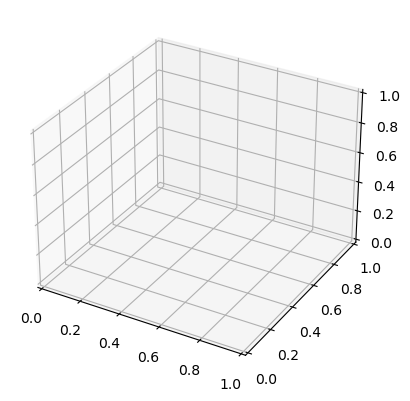

In [152]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

In [31]:
comp.describe()

Particles           Deterministic mass           Probabilistic mass  \
               Size  Fraction               Size  Fraction               Size   
Halo           5196  0.139550       5.145612e+09  0.138092       5.847603e+09   
Bulge          5400  0.145029       5.046786e+09  0.135440       5.142812e+09   
Cold disk      8088  0.217221       8.704654e+09  0.233606       8.257483e+09   
Warm disk     18550  0.498201       1.836506e+10  0.492862       1.801422e+10   

                     
           Fraction  
Halo       0.156932  
Bulge      0.138017  
Cold disk  0.221605  
Warm disk  0.483446

In [18]:
circ = gchop.preproc.jcirc(gal)


In [30]:
circ.as_dict().keys()

dict_keys(['normalized_star_energy', 'normalized_star_Jz', 'eps', 'eps_r'])

- Hacete el cluster jerarquico
- Barre 2,3,4 y 5 componentes ['normalized_star_energy', 'normalized_star_Jz', 'eps', 'eps_r']
- Barre usar todas combinaciones de
- Sacale todas las metricas que ya tenes
- Graficalo
- Y todo comparalo paso a paso con Si los elementos son 2 con JHistogram, mas de eso comparalo con AutoGausian
- Acordate de fijar semillas siempre


In [95]:
import sklearn
import pandas as pd

import itertools
from typing import Optional, List
import numpy as np

class ClusteringMethod:
    pass
class HierarchicalClustering(ClusteringMethod):
    def __init__(self, comp):
        self._comp = comp
        self._has_probs = comp.probabilities is not None
        
    def run(self, n_clusters: int = 4, linkage: str = 'ward', attributes: Optional[List[int]] = None):
        attribute_indeces = range(0, len(self._comp.attributes)) if attributes is None else attributes
        galaxy_data = self._prepare_data(attribute_indeces)
        clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        clustering.fit(galaxy_data)
        
        return np.array(clustering.labels_)
    
    def run_all(self, linkage: str = 'ward'):
        all_attributes = self._comp.attributes
        results = []
        index = []
        x = 0
        for n, amount_attributes in enumerate(range(1, len(all_attributes)+1)):
            combined_attributes = list(itertools.combinations(enumerate(all_attributes), amount_attributes))
            for attributes in combined_attributes:
                index.append(attributes)
                results.append([])
                for y, n_clusters in enumerate([2,3,4]):
                    attribute_indices = [attribute[0] for attribute in attributes]
                    results[x].append(self.run(n_clusters = n_clusters, attributes = attribute_indices))
                x=x+1
        
        index = list(map(lambda a: str(tuple(map(lambda b: b[1], a))), index))
        return pd.DataFrame(results,
        index=pd.Index(index, name='Attributes'),
        columns=pd.Index([2,3,4], name='n_clusters'))
    
    def _prepare_data(self, attribute_indices: List[int]):
        data = [[t[i] for i in attribute_indices] for t in self._comp.x_clean]
        attributes = [self._comp.attributes[i] for i in attribute_indices]
        
        galaxy_data = pd.DataFrame(data, columns = attributes)
        #Reduced data set to be able to test stuff locally
        galaxy_data = galaxy_data.head(100)
        return galaxy_data

In [ ]:
import galaxychop as gchop

gal = gchop.preproc.center_and_align(gchop.io.read_hdf5("tests/datasets/gal394242.h5"))

comp = gchop.models.AutoGaussianMixture(n_jobs=-2).decompose(gal)

In [130]:
hclustering = HierarchicalClustering(comp)
#hclustering.run()
clustering_results = hclustering.run_all()

In [114]:
class Internal:
    """Internal evaluation indexes.
    
    This class contains methods used for internal evaluation of clustering results.
    
    Parameters
    ----------
    comp: Components
        The components of a galaxy.
    
    """
    def __init__(self, comp):
        self._comp = comp
        self._has_probs = comp.probabilities is not None

    def silhouette(self, labels, **kwars):
        """The silhouette value is a measure of how similar an object is to its own cluster (cohesion)
        compared to other clusters (separation). The silhouette ranges from −1 to +1,
        where a high value indicates that the object is well matched to its own cluster and
        poorly matched to neighboring clusters. If most objects have a high value,
        then the clustering configuration is appropriate. If many points have a low or negative value,
        then the clustering configuration may have too many or too few clusters.
        """
        
        #Reduced data set to be able to test stuff locally
        galaxy_data = pd.DataFrame(self._comp.x_clean, columns = self._comp.attributes).head(100)
        return sklearn.metrics.silhouette_score(galaxy_data, labels, **kwars)

    def davies_bouldin(self, labels, **kwars):
        """Validates how well the clustering has been done is made using quantities and
        features inherent to the dataset.
        """
        
        #Reduced data set to be able to test stuff locally
        galaxy_data = pd.DataFrame(self._comp.x_clean, columns = self._comp.attributes).head(100)
        return sklearn.metrics.davies_bouldin_score(galaxy_data, labels, **kwars)

Internal evaluation: attributes='normalized_star_energy',, n_clusters=2
Silhouette:  0.14661494321943128
Davies Bouldin:  2.375036648886279
Internal evaluation: attributes='normalized_star_energy',, n_clusters=3
Silhouette:  -0.03339293152937548
Davies Bouldin:  3.773401328217617
Internal evaluation: attributes='normalized_star_energy',, n_clusters=4
Silhouette:  -0.052056382869804546
Davies Bouldin:  19.233013012458198
Internal evaluation: attributes='eps',, n_clusters=2
Silhouette:  0.36219074913930727
Davies Bouldin:  1.0492050903541204
Internal evaluation: attributes='eps',, n_clusters=3
Silhouette:  0.29769338203660367
Davies Bouldin:  1.1408448875408992
Internal evaluation: attributes='eps',, n_clusters=4
Silhouette:  0.23832918224694727
Davies Bouldin:  1.33284017694802
Internal evaluation: attributes='eps_r',, n_clusters=2
Silhouette:  0.3479039143915802
Davies Bouldin:  1.4363086114336956
Internal evaluation: attributes='eps_r',, n_clusters=3
Silhouette:  0.18025039820354988
D

/tmp/ipykernel_5431/2971002645.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


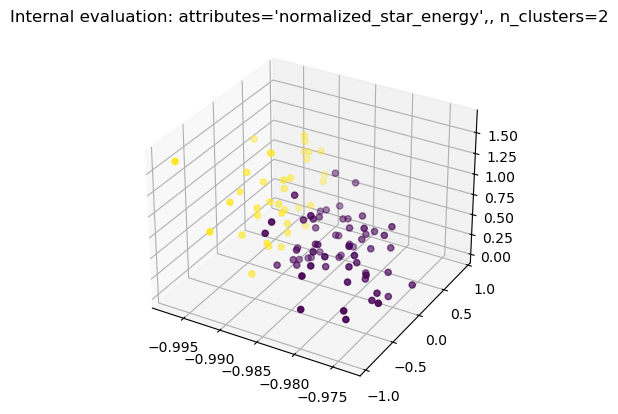

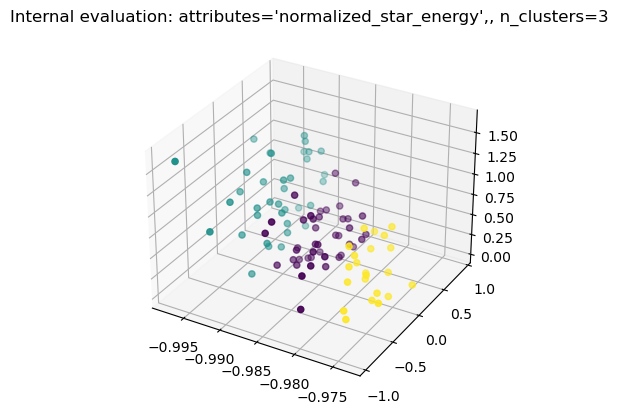

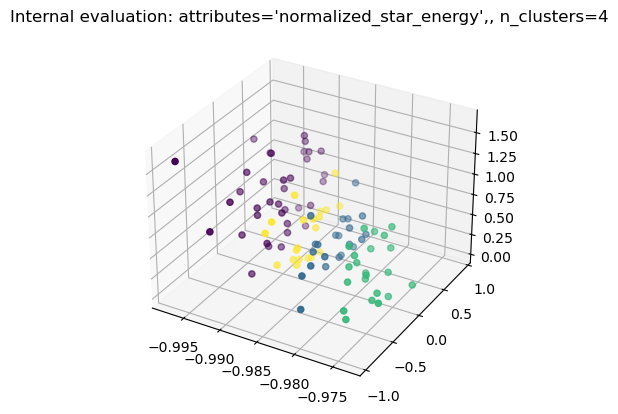

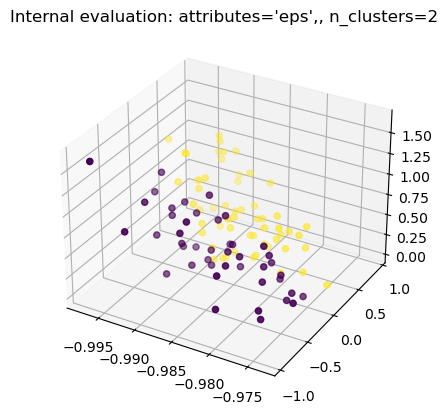

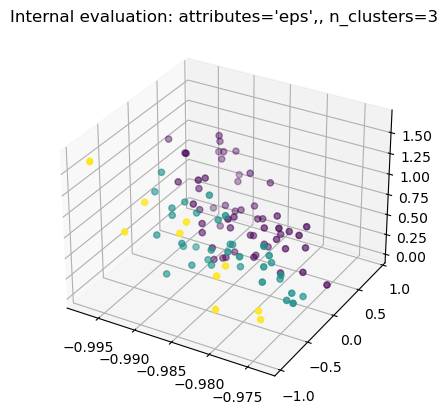

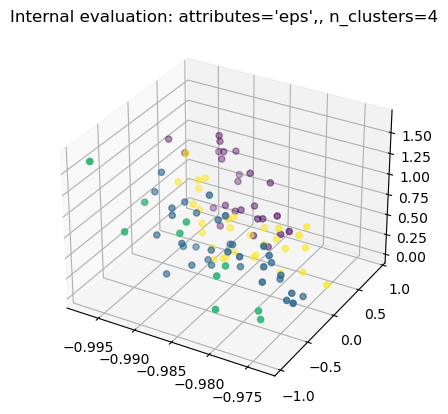

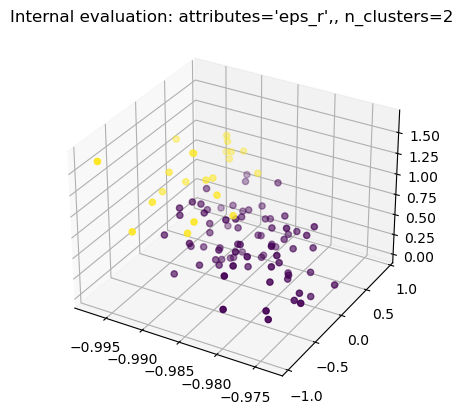

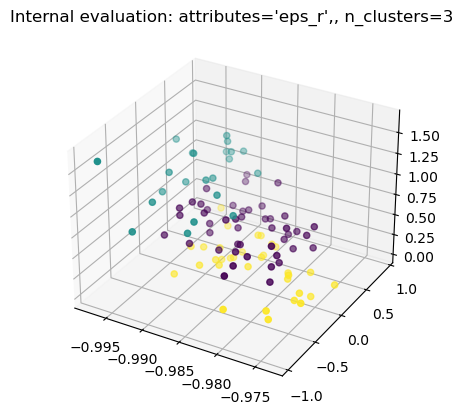

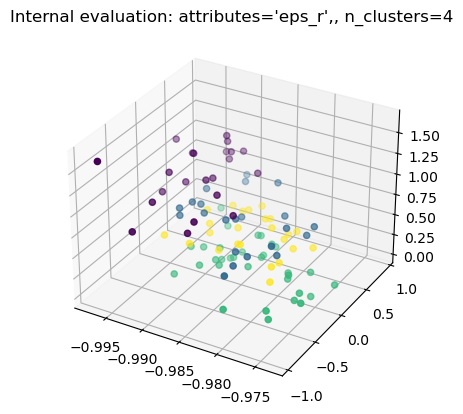

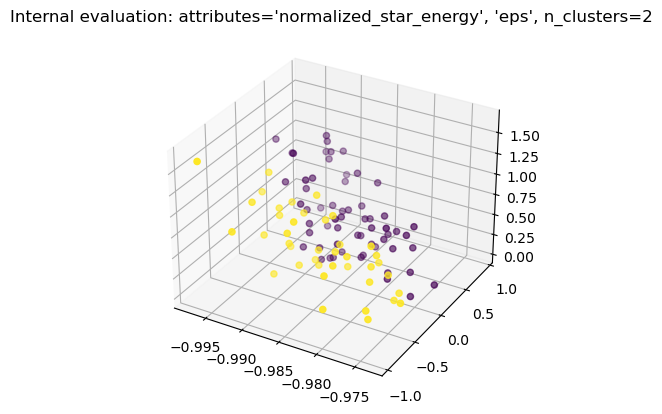

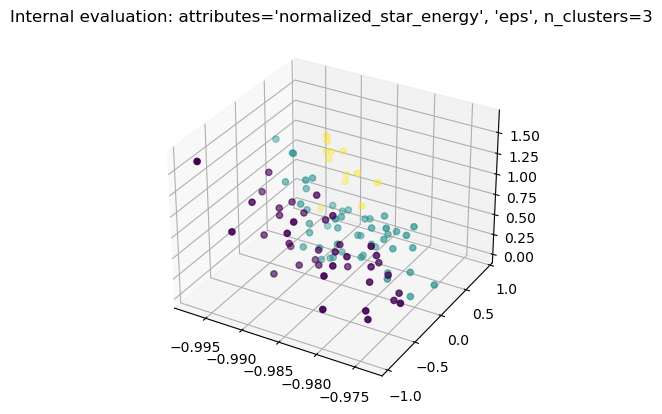

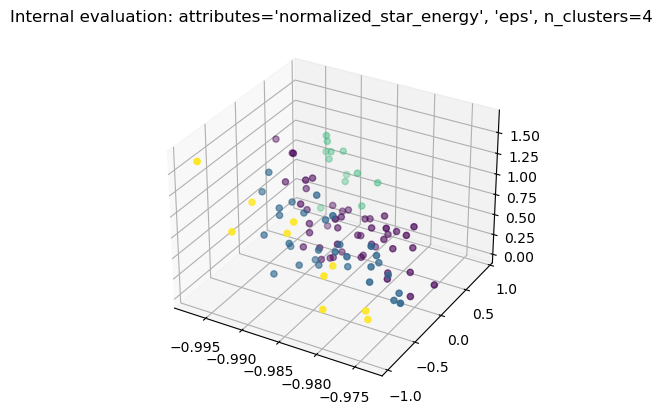

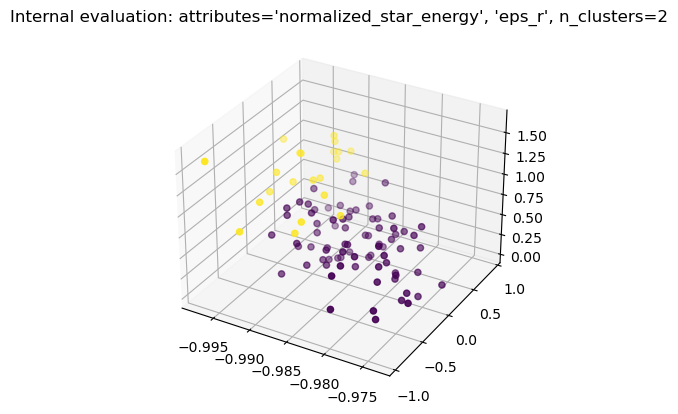

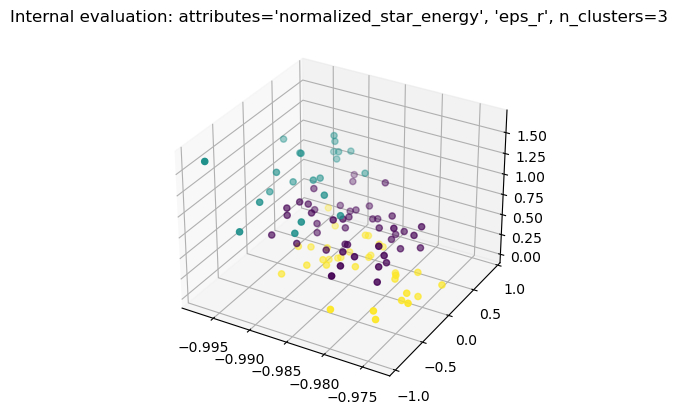

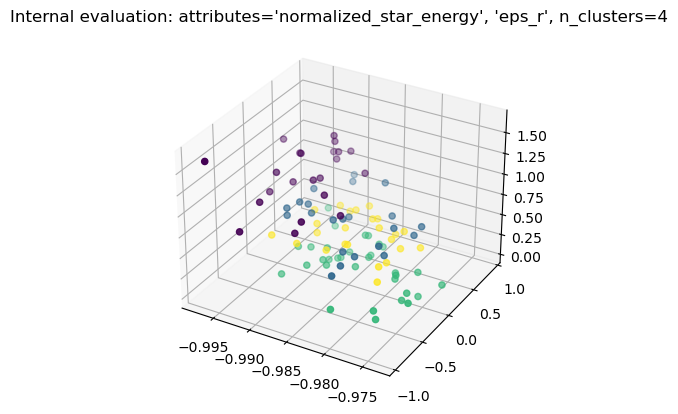

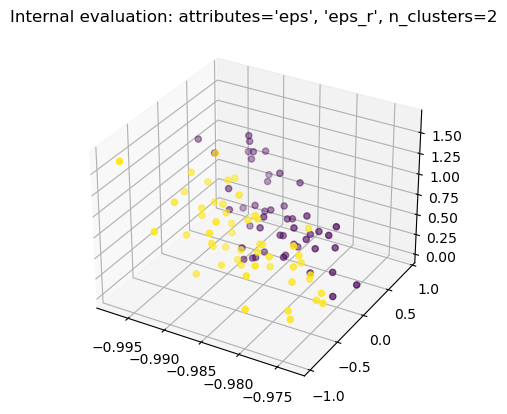

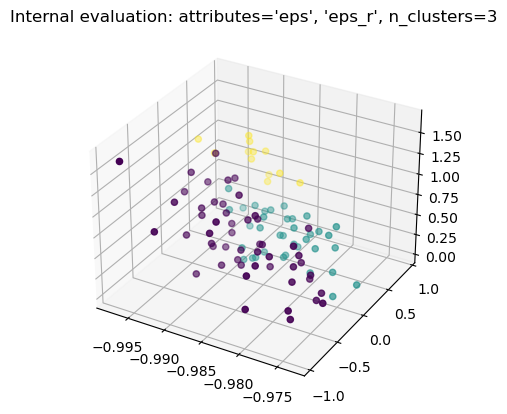

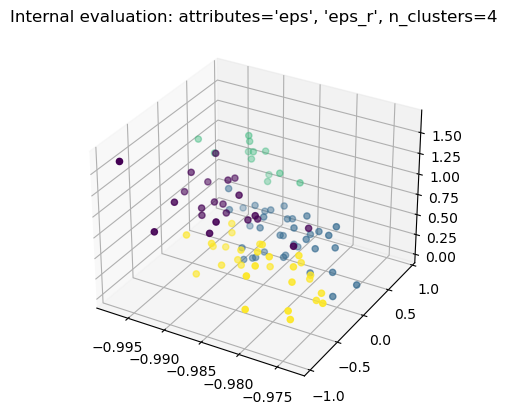

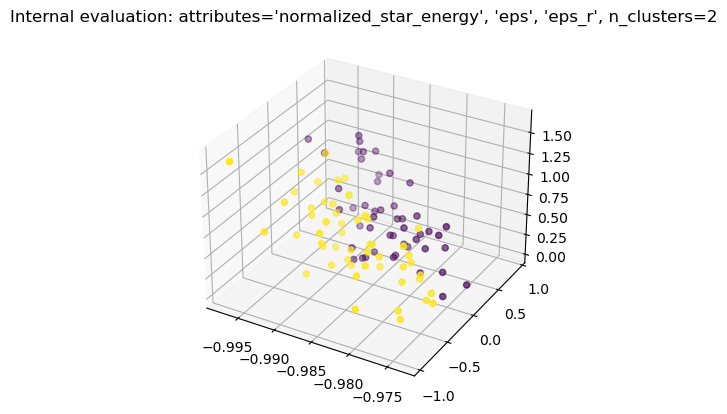

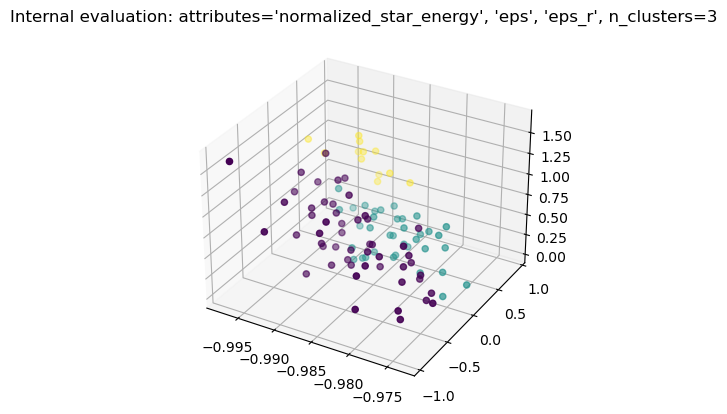

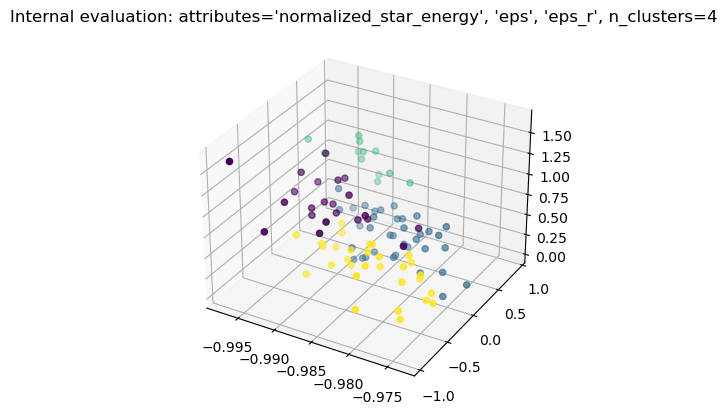

In [184]:
#gchop.JHistogram().decompose(gal)
abadi_results = gchop.models.JHistogram().decompose(gal)

# Internal evaluation
internal_evaluation = Internal(comp)
for row_name, row in clustering_results.iterrows():
    for idy, results in enumerate(row):
        column_name = clustering_results.columns[idy]
        real_row_name = row_name[1:-1]
        title = f"Internal evaluation: attributes={real_row_name}, n_clusters={column_name}"
        print(title)
        print("Silhouette: ", internal_evaluation.silhouette(results))
        print("Davies Bouldin: ", internal_evaluation.davies_bouldin(results))
        
        #Reduced data set to be able to test stuff locally
        x, y, z = np.array(comp.x_clean[:100]).T
        
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(x, y ,z, c=clustering_results[column_name][row_name])
        ax.set_title(title)
        
        # No puedo correr localmente
        #gal.plot.pairplot(attributes=["x", "y", "z"], labels=results)
        
        import pickle
        pickle.dump(fig, open(title+'.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`

        